In [1]:
from langgraph.graph import StateGraph, END
from typing import TypedDict, Dict, List, Any, Optional
from langchain_core.messages import HumanMessage
import json
from langchain_openai import ChatOpenAI
from dotenv import load_dotenv
import os
load_dotenv()
llm_key = os.getenv('llm_key')

In [2]:
model=ChatOpenAI(model="openai/gpt-oss-20b:free",
                        api_key=llm_key,
                        base_url="https://openrouter.ai/api/v1")

In [3]:
class GraphState(TypedDict):
    user_request: str
    workflow_type: str
    questions: Dict[str, Any]
    answers: Dict[str, Any]
    validation: Dict[str, Any]
    workflow: Dict[str, Any]
    form_schema: Dict[str, Any]
    excel_schema: Dict[str, Any]
    iteration_count: int
    refinement_needed: bool

In [4]:
WORKFLOW_TEMPLATES = {
    "letter_of_recommendation": {
        "description": "Generate and track letters of recommendation",
        "approvers": ["Department Head", "Dean"],
        "storage": "OneDrive/SharePoint",
        "notifications": ["Student", "Recommender", "Admin"]
    },
    "leave_application": {
        "description": "Process faculty/student leave requests",
        "approvers": ["Direct Supervisor", "HR"],
        "storage": "SharePoint",
        "notifications": ["Applicant", "Supervisor", "HR"]
    },
    "research_proposal": {
        "description": "Submit and approve research proposals",
        "approvers": ["Research Committee", "Ethics Board"],
        "storage": "SharePoint",
        "notifications": ["Researcher", "Committee Members"]
    },
    "equipment_request": {
        "description": "Request lab/office equipment",
        "approvers": ["Department Head", "Procurement"],
        "storage": "SharePoint",
        "notifications": ["Requester", "Approvers", "Procurement"]
    },
    "grade_appeal": {
        "description": "Submit and process grade appeals",
        "approvers": ["Course Instructor", "Department Head"],
        "storage": "SharePoint",
        "notifications": ["Student", "Instructor", "Admin"]
    }
}

In [6]:
def analyze_request(state: GraphState):
    """
    Analyze user request and determine workflow type and initial requirements
    """
    
    prompt = f"""
    You are a university workflow architect. Analyze this request and determine:
    1. The workflow type
    2. Key stakeholders
    3. Required information fields

    User Request: {state['user_request']}

    Available workflow types:
    {json.dumps(list(WORKFLOW_TEMPLATES.keys()), indent=2)}

    Return ONLY valid JSON in this exact format:
    {{
    "workflow_type": "one of the available types",
    "stakeholders": ["list", "of", "roles"],
    "complexity": "simple|moderate|complex",
    "estimated_steps": 5
    }}
    """
    analysis = {
        "workflow_type": "letter_of_recommendation",
        "stakeholders": ["Student", "Faculty", "Department Admin"],
        "complexity": "moderate",
        "estimated_steps": 6
    }
    
    return {
        "workflow_type": analysis["workflow_type"],
        "iteration_count": 0
    }


def generate_questions(state: GraphState):
    """
    Generate comprehensive questions based on workflow type
    """
    
    workflow_type = state.get("workflow_type", "letter_of_recommendation")
    template = WORKFLOW_TEMPLATES.get(workflow_type, {})
    
    prompt = f"""
You are designing a Microsoft Forms input for a university workflow.

Workflow: {workflow_type}
Description: {template.get('description', '')}

Generate questions that will collect ALL necessary information.
Include fields for: requester info, request details, supporting documents, approvers.

Return ONLY valid JSON:
{{
  "workflow_type": "{workflow_type}",
  "form_title": "...",
  "form_description": "...",
  "required_fields": [
    {{
      "id": "requester_name",
      "question": "Full Name",
      "type": "text",
      "required": true,
      "validation": "string",
      "placeholder": "Enter your full name"
    }}
  ],
  "optional_fields": [
    {{
      "id": "additional_notes",
      "question": "Additional Comments",
      "type": "textarea",
      "required": false
    }}
  ],
  "file_uploads": [
    {{
      "id": "supporting_docs",
      "label": "Supporting Documents",
      "accepted_types": [".pdf", ".docx"],
      "max_size_mb": 10
    }}
  ]
}}
"""

    # Simulated response - replace with actual model call
    questions = {
        "workflow_type": workflow_type,
        "form_title": f"{workflow_type.replace('_', ' ').title()} Request",
        "form_description": template.get('description', ''),
        "required_fields": [
            {
                "id": "requester_name",
                "question": "Full Name",
                "type": "text",
                "required": True,
                "validation": "string",
                "placeholder": "Enter your full name"
            },
            {
                "id": "requester_email",
                "question": "University Email",
                "type": "email",
                "required": True,
                "validation": "email",
                "placeholder": "your.name@university.edu"
            },
            {
                "id": "requester_id",
                "question": "Student/Employee ID",
                "type": "text",
                "required": True,
                "validation": "string",
                "placeholder": "ID number"
            },
            {
                "id": "request_details",
                "question": "Request Details",
                "type": "textarea",
                "required": True,
                "validation": "string",
                "placeholder": "Provide detailed information about your request"
            }
        ],
        "optional_fields": [
            {
                "id": "additional_notes",
                "question": "Additional Comments",
                "type": "textarea",
                "required": False
            }
        ],
        "file_uploads": [
            {
                "id": "supporting_docs",
                "label": "Supporting Documents",
                "accepted_types": [".pdf", ".docx"],
                "max_size_mb": 10
            }
        ]
    }
    
    return {"questions": questions}


def collect_answers(state: GraphState):
    """
    Human-in-the-loop: Collect answers to generated questions
    """
    
    questions = state.get("questions", {})
    
    if not questions or "required_fields" not in questions:
        print("\n❌ No questions found in state.")
        return state

    answers = {}
    
    print(f"\n{'='*70}")
    print(f"📋 {questions.get('form_title', 'Workflow Configuration')}")
    print(f"{'='*70}")
    print(f"\n{questions.get('form_description', '')}\n")

    # Required fields
    print("\n🔴 REQUIRED FIELDS:\n")
    for field in questions["required_fields"]:
        while True:
            val = input(f"{field['question']} [{field['type']}]: ").strip()
            if val or not field['required']:
                answers[field["id"]] = val
                break
            else:
                print("   ⚠️  This field is required. Please provide a value.")

    # Optional fields
    if questions.get("optional_fields"):
        print("\n🔵 OPTIONAL FIELDS (press Enter to skip):\n")
        for field in questions["optional_fields"]:
            val = input(f"{field['question']} [{field['type']}]: ").strip()
            if val:
                answers[field["id"]] = val

    # File uploads (simulated)
    if questions.get("file_uploads"):
        print("\n📎 FILE UPLOADS:\n")
        for upload in questions["file_uploads"]:
            val = input(f"{upload['label']} (path or 'skip'): ").strip()
            if val and val.lower() != 'skip':
                answers[upload["id"]] = val

    return {"answers": answers}


def validate_answers(state: GraphState):
    """
    Validate collected answers for completeness and correctness
    """
    
    questions = state.get("questions", {})
    answers = state.get("answers", {})
    
    missing = []
    invalid = []
    
    # Check required fields
    for field in questions.get("required_fields", []):
        field_id = field["id"]
        
        if field_id not in answers or not answers[field_id]:
            missing.append(field["question"])
        else:
            # Basic validation
            val = answers[field_id]
            if field.get("validation") == "email" and "@" not in val:
                invalid.append(f"{field['question']} (invalid email format)")
    
    is_valid = len(missing) == 0 and len(invalid) == 0
    
    validation_result = {
        "valid": is_valid,
        "missing": missing,
        "invalid": invalid
    }
    
    if not is_valid:
        print("\n❌ VALIDATION FAILED:")
        if missing:
            print(f"\n   Missing fields: {', '.join(missing)}")
        if invalid:
            print(f"\n   Invalid fields: {', '.join(invalid)}")
    
    return {
        "validation": validation_result,
        "refinement_needed": not is_valid
    }


def generate_form_schema(state: GraphState):
    """
    Generate Microsoft Forms JSON schema
    """
    
    questions = state.get("questions", {})
    
    form_schema = {
        "title": questions.get("form_title", "University Workflow Form"),
        "description": questions.get("form_description", ""),
        "settings": {
            "one_response_per_user": True,
            "allow_anonymous": False,
            "confirmation_message": "Your request has been submitted successfully!"
        },
        "questions": []
    }
    
    # Add required fields
    for idx, field in enumerate(questions.get("required_fields", []), 1):
        form_schema["questions"].append({
            "id": f"q{idx}",
            "type": field["type"],
            "title": field["question"],
            "required": field["required"],
            "validation": field.get("validation", ""),
            "placeholder": field.get("placeholder", "")
        })
    
    # Add optional fields
    for idx, field in enumerate(questions.get("optional_fields", []), len(form_schema["questions"]) + 1):
        form_schema["questions"].append({
            "id": f"q{idx}",
            "type": field["type"],
            "title": field["question"],
            "required": False
        })
    
    return {"form_schema": form_schema}


def generate_excel_schema(state: GraphState):
    """
    Generate Excel table schema for tracking submissions
    """
    
    questions = state.get("questions", {})
    workflow_type = state.get("workflow_type", "")
    
    # Standard columns for all workflows
    columns = [
        {"name": "SubmissionID", "type": "text"},
        {"name": "Timestamp", "type": "datetime"},
        {"name": "Status", "type": "choice", "choices": ["Pending", "Approved", "Rejected", "In Review"]},
    ]
    
    # Add columns from form fields
    for field in questions.get("required_fields", []):
        columns.append({
            "name": field["question"].replace(" ", "_"),
            "type": "text"
        })
    
    # Add approval tracking columns
    columns.extend([
        {"name": "ApproverName", "type": "text"},
        {"name": "ApprovalDate", "type": "datetime"},
        {"name": "Comments", "type": "text"}
    ])
    
    excel_schema = {
        "table_name": f"{workflow_type}_tracking",
        "location": "SharePoint/Shared Documents",
        "columns": columns,
        "auto_sync": True
    }
    
    return {"excel_schema": excel_schema}


def generate_power_automate_workflow(state: GraphState):
    """
    Generate complete Power Automate workflow JSON
    """
    
    answers = state.get("answers", {})
    form_schema = state.get("form_schema", {})
    excel_schema = state.get("excel_schema", {})
    workflow_type = state.get("workflow_type", "")
    template = WORKFLOW_TEMPLATES.get(workflow_type, {})
    
    workflow = {
        "name": f"{workflow_type.replace('_', ' ').title()} Workflow",
        "description": f"Automated workflow for {template.get('description', '')}",
        "trigger": {
            "type": "Microsoft Forms",
            "operation": "When a new response is submitted",
            "form_id": "{FORM_ID}",
            "parameters": {
                "form_name": form_schema.get("title", "")
            }
        },
        "actions": [
            {
                "step": 1,
                "name": "Initialize Variables",
                "type": "Initialize variable",
                "variables": [
                    {"name": "SubmissionID", "type": "String", "value": "@{guid()}"},
                    {"name": "Status", "type": "String", "value": "Pending"},
                    {"name": "ApprovalURL", "type": "String", "value": ""}
                ]
            },
            {
                "step": 2,
                "name": "Get Response Details",
                "type": "Microsoft Forms",
                "operation": "Get response details",
                "parameters": {
                    "form_id": "{FORM_ID}",
                    "response_id": "@{triggerBody()?['resourceData']?['id']}"
                }
            },
            {
                "step": 3,
                "name": "Add Row to Excel",
                "type": "Excel Online (Business)",
                "operation": "Add a row into a table",
                "parameters": {
                    "location": excel_schema.get("location", ""),
                    "table": excel_schema.get("table_name", ""),
                    "values": {
                        "SubmissionID": "@{variables('SubmissionID')}",
                        "Timestamp": "@{utcNow()}",
                        "Status": "@{variables('Status')}",
                        **{field["id"]: f"@{{body('Get_response_details')?['{field['id']}'] }}" 
                           for field in form_schema.get("questions", [])[:3]}
                    }
                }
            },
            {
                "step": 4,
                "name": "Send Confirmation Email",
                "type": "Office 365 Outlook",
                "operation": "Send an email (V2)",
                "parameters": {
                    "to": f"@{{body('Get_response_details')?['requester_email']}}",
                    "subject": f"Your {workflow_type.replace('_', ' ').title()} Request has been received",
                    "body": f"""
<p>Dear @{{body('Get_response_details')?['requester_name']}},</p>
<p>Your request has been successfully submitted.</p>
<p><strong>Submission ID:</strong> @{{variables('SubmissionID')}}</p>
<p><strong>Status:</strong> Pending Review</p>
<p>You will be notified once your request has been reviewed.</p>
<p>Best regards,<br>University Administration</p>
"""
                }
            }
        ],
        "approval_flow": []
    }
    
    # Add approval steps for each approver
    for idx, approver in enumerate(template.get("approvers", []), 5):
        workflow["approval_flow"].append({
            "step": idx,
            "name": f"Approval - {approver}",
            "type": "Start and wait for an approval",
            "approval_type": "Approve/Reject - First to respond",
            "parameters": {
                "title": f"{workflow_type.replace('_', ' ').title()} Approval Request",
                "assigned_to": f"{{{approver.upper().replace(' ', '_')}_EMAIL}}",
                "details": f"""
Requester: @{{body('Get_response_details')?['requester_name']}}
Submission ID: @{{variables('SubmissionID')}}

Please review and approve/reject this request.
""",
                "item_link": "@{variables('ApprovalURL')}",
                "item_link_description": "View Full Request"
            }
        })
        
        # Update Excel after each approval
        workflow["approval_flow"].append({
            "step": idx + 0.1,
            "name": f"Update Excel - {approver} Decision",
            "type": "Excel Online (Business)",
            "operation": "Update a row",
            "parameters": {
                "table": excel_schema.get("table_name", ""),
                "key_column": "SubmissionID",
                "key_value": "@{variables('SubmissionID')}",
                "values": {
                    "Status": f"@{{body('Approval_-_{approver}')?['outcome']}}",
                    "ApproverName": f"{approver}",
                    "ApprovalDate": "@{utcNow()}",
                    "Comments": f"@{{body('Approval_-_{approver}')?['comments']}}"
                }
            }
        })
    
    # Final notification
    workflow["actions"].append({
        "step": len(workflow["approval_flow"]) + 5,
        "name": "Send Final Notification",
        "type": "Office 365 Outlook",
        "operation": "Send an email (V2)",
        "parameters": {
            "to": f"@{{body('Get_response_details')?['requester_email']}}",
            "subject": f"Your {workflow_type.replace('_', ' ').title()} Request - Final Status",
            "body": """
<p>Your request has been processed.</p>
<p><strong>Final Status:</strong> @{variables('Status')}</p>
<p>Thank you.</p>
"""
        }
    })
    
    return {"workflow": workflow}


def display_workflow(state: GraphState):
    """
    Display the generated workflow to the admin user
    """
    
    workflow = state.get("workflow", {})
    form_schema = state.get("form_schema", {})
    excel_schema = state.get("excel_schema", {})
    
    print("\n" + "="*70)
    print("✅ WORKFLOW GENERATED SUCCESSFULLY")
    print("="*70)
    
    print(f"\n📋 Workflow Name: {workflow.get('name', '')}")
    print(f"📝 Description: {workflow.get('description', '')}")
    
    print("\n🔧 COMPONENTS:")
    print(f"  • Microsoft Form: {form_schema.get('title', '')}")
    print(f"  • Excel Tracking: {excel_schema.get('table_name', '')}")
    print(f"  • Total Steps: {len(workflow.get('actions', [])) + len(workflow.get('approval_flow', []))}")
    
    print("\n📊 WORKFLOW STEPS:")
    for action in workflow.get("actions", [])[:5]:
        print(f"  {action['step']}. {action['name']}")
    
    if workflow.get("approval_flow"):
        print("\n✅ APPROVAL FLOW:")
        for approval in workflow.get("approval_flow", []):
            if isinstance(approval.get('step'), int):
                print(f"  • {approval['name']}")
    
    print("\n💾 Export Options:")
    print("  1. Power Automate JSON")
    print("  2. Microsoft Forms JSON")
    print("  3. Excel Schema")
    print("  4. Complete Package (All)")
    
    choice = input("\nSelect export option (1-4): ").strip()
    
    if choice == "1":
        print("\n" + json.dumps(workflow, indent=2))
    elif choice == "2":
        print("\n" + json.dumps(form_schema, indent=2))
    elif choice == "3":
        print("\n" + json.dumps(excel_schema, indent=2))
    elif choice == "4":
        package = {
            "workflow": workflow,
            "form": form_schema,
            "excel": excel_schema
        }
        print("\n" + json.dumps(package, indent=2))
    
    return state

def should_refine_questions(state: GraphState) -> str:
    """
    Route based on validation results
    """
    if state.get("refinement_needed", False):
        iter_count = state.get("iteration_count", 0)
        if iter_count < 3:
            print("\n🔄 Refining questions based on validation feedback...")
            return "refine"
        else:
            print("\n⚠️ Max iterations reached. Proceeding with current answers...")
            return "proceed"
    return "proceed"


def route_after_validation(state: GraphState) -> str:
    """
    Determine next step after validation
    """
    return "generate_schemas" if state.get("validation", {}).get("valid") else "collect"

In [7]:
graph = StateGraph(GraphState)

# Add nodes
graph.add_node("analyze_request", analyze_request)
graph.add_node("generate_questions", generate_questions)
graph.add_node("collect_answers", collect_answers)
graph.add_node("validate_answers", validate_answers)
graph.add_node("generate_form_schema", generate_form_schema)
graph.add_node("generate_excel_schema", generate_excel_schema)
graph.add_node("generate_workflow", generate_power_automate_workflow)
graph.add_node("display_workflow", display_workflow)

# Define edges
graph.set_entry_point("analyze_request")
graph.add_edge("analyze_request", "generate_questions")
graph.add_edge("generate_questions", "collect_answers")
graph.add_edge("collect_answers", "validate_answers")

# Conditional edge after validation
graph.add_conditional_edges(
    "validate_answers",
    route_after_validation,
    {
        "collect": "collect_answers",
        "generate_schemas": "generate_form_schema"
    }
)

graph.add_edge("generate_form_schema", "generate_excel_schema")
graph.add_edge("generate_excel_schema", "generate_workflow")
graph.add_edge("generate_workflow", "display_workflow")
graph.add_edge("display_workflow", END)


app =  graph.compile()

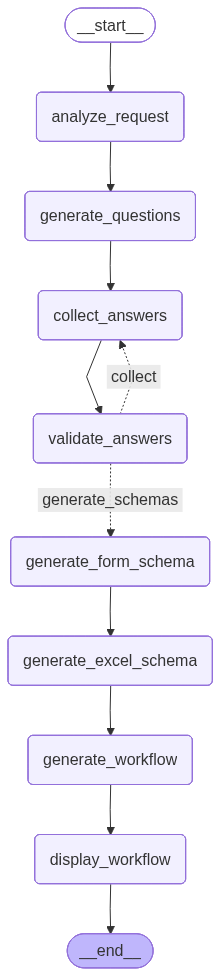

In [8]:
from IPython.display import Image,display
display(Image(app.get_graph().draw_mermaid_png()))

In [ ]:
user_input = "I need a system for students to request letters of recommendation from faculty"
initial_state = {
        "user_request": user_input,
        "workflow_type": "",
        "questions": {},
        "answers": {},
        "validation": {},
        "workflow": {},
        "form_schema": {},
        "excel_schema": {},
        "iteration_count": 0,
        "refinement_needed": False
    }
final_state = app.invoke(initial_state)
print(json.dumps(final_state["workflow"], indent=2))


📋 Letter Of Recommendation Request

Generate and track letters of recommendation


🔴 REQUIRED FIELDS:


🔵 OPTIONAL FIELDS (press Enter to skip):


📎 FILE UPLOADS:


❌ VALIDATION FAILED:

   Invalid fields: University Email (invalid email format)

📋 Letter Of Recommendation Request

Generate and track letters of recommendation


🔴 REQUIRED FIELDS:


🔵 OPTIONAL FIELDS (press Enter to skip):


📎 FILE UPLOADS:


❌ VALIDATION FAILED:

   Invalid fields: University Email (invalid email format)

📋 Letter Of Recommendation Request

Generate and track letters of recommendation


🔴 REQUIRED FIELDS:

   ⚠️  This field is required. Please provide a value.
   ⚠️  This field is required. Please provide a value.
